
<h2 align=center>Anomaly Detection in Time Series with Keras</h2>


## Package load

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.3.0


## Load and Inspect

In [2]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [3]:
df.shape

(8192, 2)

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Preprocessing

In [5]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.date, y=train.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [7]:
offset=.0000001

train['movingavg']=train['close']-train['close'].rolling(window=7).mean()
test['movingavg']=test['close']-test['close'].rolling(window=7).mean()

train['offset']=train['movingavg']+abs(train['movingavg'].min())+offset
test['offset']=test['movingavg']+abs(test['movingavg'].min())+offset

train['transformed']=np.log(train['offset'])-np.log(abs(train['movingavg'].min())+offset)
test['transformed']=np.log(test['offset'])-np.log(abs(test['movingavg'].min())+offset)

train['transformed']=train['transformed'].fillna(0)
test['transformed']=test['transformed'].fillna(0)

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.date, y=train.transformed,
                    mode='lines',
                    name='transformed close'))
fig.update_layout(showlegend=True)
fig.show()



## Training and Test:

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
time_steps = 30

X_train, y_train = create_dataset(train[['transformed']], train.transformed, time_steps)
X_test, y_test = create_dataset(test[['transformed']], test.transformed, time_steps)

print(X_train.shape)

(6523, 30, 1)


## Architecture

In [11]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
dropout_20 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 64)           

## Task 6: Train the Autoencoder

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 20s 106ms/step - loss: 0.0691 - val_loss: 0.1072
Epoch 2/100
184/184 [==============================] - 18s 100ms/step - loss: 0.0581 - val_loss: 0.0883
Epoch 3/100
184/184 [==============================] - 19s 101ms/step - loss: 0.0535 - val_loss: 0.0792
Epoch 4/100
184/184 [==============================] - 18s 100ms/step - loss: 0.0519 - val_loss: 0.0773
Epoch 5/100
184/184 [==============================] - 19s 101ms/step - loss: 0.0513 - val_loss: 0.0744
Epoch 6/100
184/184 [==============================] - 19s 101ms/step - loss: 0.0503 - val_loss: 0.0749
Epoch 7/100
184/184 [==============================] - 19s 101ms/step - loss: 0.0503 - val_loss: 0.0754
Epoch 8/100
184/184 [==============================] - 19s 101ms/step - loss: 0.0500 - val_loss: 0.0756


## Metrics

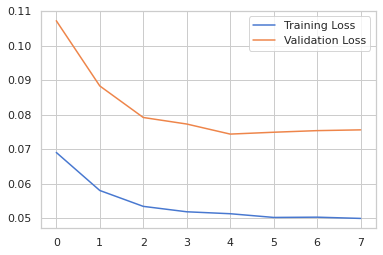

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [27]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [28]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 26ms/step - loss: 0.0851


0.08514471352100372

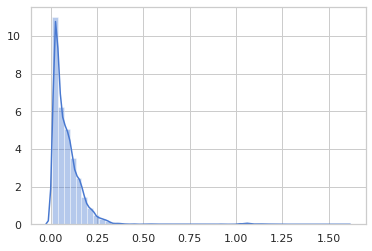

In [29]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [30]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

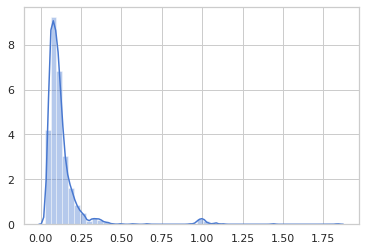

In [31]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Detection test

In [32]:
THRESHOLD = np.percentile(test_mae_loss,95)

print("Threshold: " + str(THRESHOLD))

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

Threshold: 0.27457294274535254


In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [34]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,movingavg,offset,transformed,loss,threshold,anomaly
7257,2014-10-14,1877.70,-44.527143,107.345714,-0.346989,0.296410,0.274573,True
7263,2014-10-22,1927.11,32.522857,184.395714,0.194040,0.274601,0.274573,True
7300,2014-12-15,1989.63,-45.931429,105.941429,-0.360157,0.279151,0.274573,True
7315,2015-01-07,2025.90,-22.258571,129.614286,-0.158481,0.276872,0.274573,True
7473,2015-08-24,1893.21,-145.410000,6.462857,-3.156972,0.572258,0.274573,True


In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test[time_steps:].close,
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=anomalies.close,
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()